#**Teaching my PC how to read numbers**
## A convolutional NN for the SVHN Dataset
  
The scope of this Notebook is to build and fit a fairy simple model that is able to recognize and predict the house numbers in images taken from Google Street View. 

I will tackle the problem with a **Convolutional Neural Network** that was conceived for a similar, yet far more complex, task: that of License Plate Detection and Recognition (LPDR). 
I have successfully used the same model on the huge (about 130.000 unique images) Chinese City Parking Dataset, with slow but precise results.

All the ideas behind my work are explained in much greater details in [this article on my website](https://www.andreapasotti.it/home/statistics/teaching-my-pc-to-read-numbers/), therefore feel free to read it if you want! 😊



P.S. I am definitely far from being an expert in NNs, and the same applies for Python programming (which is not yet my main language) so please fogive my (sometimes) bad code :)

### Author: 
- Andrea Pasotti (www.andreapasotti.it | mail@andreapasotti.it)

The data were provided during the course of ADNE (Aprendizagem com Dados Não Estruturados) by Professor Ludwig Krippahl, at the NOVA University of Lisboa in May 2020.


Mounting Drive

In [186]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Introduction
- Importing Data & Libraries
- Data Pre Processing
- Showing Sample Data

In [187]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import IPython.display as display
import matplotlib.pyplot as plt

print(tf.__version__)     #2.4.1

2.4.1


### Pre Processing Functions

In [188]:
" PRE PROCESSING FUNCTIONS "
#    - Decoding tfrecords and Parsing the files
#    - Encoding the labels

# Create a dictionary describing the features.
image_feature_description = {
            'label':  tf.io.FixedLenFeature([6], tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
        }

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)


num_seq = 11
# Creating the ENCODING of the classes
def buildLabels(parsed_data):
  num0 = parsed_data['label'][0]
  num0_enc = tf.keras.backend.one_hot(num0,num_seq)
  num1 = parsed_data['label'][1]
  num1_enc = tf.keras.backend.one_hot(num1,num_seq)
  num2 = parsed_data['label'][2]
  num2_enc = tf.keras.backend.one_hot(num2,num_seq)
  num3 = parsed_data['label'][3]
  num3_enc = tf.keras.backend.one_hot(num3,num_seq)
  num4 = parsed_data['label'][4]
  num4_enc = tf.keras.backend.one_hot(num4,num_seq)
  num5 = parsed_data['label'][5]
  num5_enc = tf.keras.backend.one_hot(num5,num_seq)
  label = tf.stack([num0_enc, num1_enc, num2_enc, num3_enc, num4_enc, num5_enc])
  return label


def buildInputsLabels(parsed_data):
  # Images
  imageraw = parsed_data['image_raw']
  imagemat = tf.io.decode_jpeg(imageraw, channels=3)
  imagemat = tf.cast(imagemat,dtype=tf.float32)
  imagemat = 1/255*imagemat
  # Labels  
  labels = buildLabels(parsed_data)  
  return   imagemat,  labels


In [189]:
# Pretty Ugly Function to show labels
def decode_label(encoded_lab):
    sequence = 6*[0]
    for i in range(encoded_lab.numpy().shape[0]):
      for j in range(encoded_lab.numpy().shape[1]):
        if encoded_lab[i][j] == 1:
          sequence[i] = j
    # Real Length
    N = 6 - sequence.count(10)
    return sequence[0:N]


### Importing Datasets and Pre Processing 
I have this file saved in my main repo in Google Colab, all data are stored in the folder:

"*Colab Notebooks > DATA > SVHN*"

In [190]:
# Setting Working Directory
dataDir = '/content/drive/My Drive/Colab Notebooks/DATA/SVHN/'


In [191]:
# Importing the Data
train_raw_image_dataset = tf.data.TFRecordDataset(dataDir + 'images_train.tfrecords') 
valid_raw_image_dataset = tf.data.TFRecordDataset(dataDir + 'images_validation.tfrecords') 
test_raw_image_dataset  = tf.data.TFRecordDataset(dataDir + 'images_test.tfrecords')

In [192]:
# PARSING DATASETS
# Stage 1
train_parsed_image_dataset = train_raw_image_dataset.map(_parse_image_function)
valid_parsed_image_dataset = valid_raw_image_dataset.map(_parse_image_function)
test_parsed_image_dataset  = test_raw_image_dataset.map(_parse_image_function)
# Stage 2
trainData = train_parsed_image_dataset.map(buildInputsLabels).shuffle(5000)
validData = valid_parsed_image_dataset.map(buildInputsLabels)
testData  = test_parsed_image_dataset.map(buildInputsLabels)

In [193]:
# Counting The Occurrences
trainDim = 0
validDim = 0
testDim  = 0

for item in trainData:
  trainDim += 1
for item in validData:
  validDim += 1
for item in testData:
  testDim += 1

print(trainDim)   #123922
print(validDim)   #30981
print(testDim)    #30981

123922
30981
30981


### Showing Sample Data

In [194]:
import IPython.display as display

# Iterator to the Training Set
newIt = iter(trainData)
data = next(newIt)

# Shapes
print(data[0].shape)   #Image
print(data[1].shape)   #License Plate Number (Encoded)

(48, 64, 3)
(6, 11)


[2, 8]


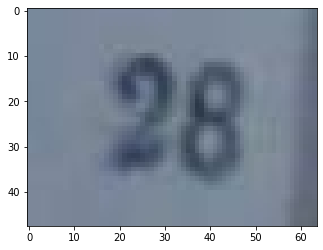

In [195]:
""" -------- PRINTING THE IMAGES -------- """
##  [This cell can be run multiple times]  ##

curr_image, curr_numb = next(newIt)

# Displaying the image:
im = tf.squeeze(curr_image).numpy()
plt.imshow(im)

# Displaying its label:
print(decode_label(curr_numb))

## Building The Model [Simple **Convolution**]

In [196]:
""" LIBRARIES for the NN PART - FUNCTIONAL KERAS """
from tensorflow import keras
from tensorflow.keras import layers

# KERAS FUNCTIONAL 
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Some useful layers we will insert in our model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from keras.callbacks import ModelCheckpoint

In [197]:
""" BUILDING FUNCTIONAL MODEL """

visible = Input(shape=(48, 64, 3), name='visible')

layer = Conv2D(32, (12,16), padding='same', name='layer1')(visible)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(64, (12,16), padding='same', name='layer2', strides=2)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(64, (6,8), padding='same', name='layer3', strides=2)(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size=(2, 2), padding='same')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(128, (6,8), padding='same', name='layer4')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size=(2, 2), padding='same')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(128, (3,4), padding='same', name='layer5')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(256, (3,4), padding='same', name='layer6')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Conv2D(256, (3,4), padding='same', name='layer7')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Flatten()(layer)

layer = Dense(6*11)(layer)
layer = Reshape( (6, 11) )(layer)

output = Activation("softmax")(layer)

model_f = Model(inputs = visible, outputs = output)
model_f.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
visible (InputLayer)         [(None, 48, 64, 3)]       0         
_________________________________________________________________
layer1 (Conv2D)              (None, 48, 64, 32)        18464     
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 64, 32)        128       
_________________________________________________________________
activation_32 (Activation)   (None, 48, 64, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 64, 32)        0         
_________________________________________________________________
layer2 (Conv2D)              (None, 24, 32, 64)        393280    
_________________________________________________________________
batch_normalization_29 (Batc (None, 24, 32, 64)        256 

### Importing The Weights (Optional)
Even if this model is trainable very fast, reaching more than 96% of accuracy on the Validation Set in less than 5 epochs, I am providing in GitHub also the weights of the final version (15 epochs more or less), ready to be loaded.

In [198]:
""" Importing Weights """
weights_path = '/content/drive/My Drive/Colab Notebooks/WEIGHTS/SVHN/v01_14epochs'
model_f.load_weights(weights_path)

Final Specifics of the Model

In [199]:
""" SPECIFICS of the MODEL """

# Hyperparameters
BS = 10
NUM_EPOCHS = 14

# Optimizer - ADAM
LR = 0.0001
opt = keras.optimizers.Adam(learning_rate = LR)

# Loss Function
loss_fctn = tf.keras.losses.CategoricalCrossentropy()

# Compiling the model
model_f.compile(optimizer=opt, 
                loss = loss_fctn,
                metrics = ['categorical_accuracy'])

# Batch Division
batched_train = trainData.batch(BS)
batched_val = validData.batch(BS)

### Running The Model

In [ ]:
# Running the Model
history = model_f.fit(batched_train, validation_batch_size=BS,
                      validation_data = batched_val, epochs=NUM_EPOCHS)


Epoch 1/14
12393/12393 [==============================] - 186s 15ms/step - loss: 0.8853 - categorical_accuracy: 0.7084 - val_loss: 0.2810 - val_categorical_accuracy: 0.9104
Epoch 2/14
12393/12393 [==============================] - 184s 15ms/step - loss: 0.2890 - categorical_accuracy: 0.9102 - val_loss: 0.1744 - val_categorical_accuracy: 0.9468
Epoch 3/14
12393/12393 [==============================] - 185s 15ms/step - loss: 0.1947 - categorical_accuracy: 0.9405 - val_loss: 0.1493 - val_categorical_accuracy: 0.9549
Epoch 4/14
12393/12393 [==============================] - 185s 15ms/step - loss: 0.1553 - categorical_accuracy: 0.9532 - val_loss: 0.1031 - val_categorical_accuracy: 0.9693
Epoch 5/14
12393/12393 [==============================] - 180s 14ms/step - loss: 0.1314 - categorical_accuracy: 0.9603 - val_loss: 0.1020 - val_categorical_accuracy: 0.9697
Epoch 6/14
12393/12393 [==============================] - 184s 15ms/step - loss: 0.1157 - categorical_accuracy: 0.9653 - val_loss: 0.08

Saving Model's Weights

In [200]:
# Saving Model's Weights
#weights_path = '/content/drive/My Drive/Colab Notebooks/WEIGHTS/SVHN/v01_14epochs'
#model_f.save_weights(weights_path)

## Evaluate Model's Goodness

### TEST SET

In [201]:
# Evaluation over TEST SET [97.80%]
batched_test = testData.batch(1)

result = model_f.evaluate(batched_test)
print("TEST Set Results: ")
dict(zip(model_f.metrics_names, result))

30981/30981 [==============================] - 121s 4ms/step - loss: 0.0721 - categorical_accuracy: 0.9785
TEST Set Results: 


{'categorical_accuracy': 0.9785944223403931, 'loss': 0.07304628193378448}

### Practical Verification over single TEST SET images

In [ ]:
### PREDICT single image
#    - Takes as input a Numpy tensor of shape: (48,64,1)
#    - Decode support function: 
#           -> Assigns to each label the maximum value of the predicted probability

def decode(encoded_tensor):
  label = [0]*6
  for ii in range(0,6):
    label[ii] = np.argmax(encoded_tensor[0][ii])
  return label

def predict_single_image(tensor):
  # We need to augment the dimension to --> (1,48,64,1)
  img = np.expand_dims(tensor, axis=0)
  res = model_f.predict(img)
  return decode(res)

# Utility to remove the 10s
def decode_final(pred_label):
    N = 6 - pred_label.count(10)
    return pred_label[0:N]


In [ ]:
import IPython.display as display

# Iterator to the TEST SET
newIt = iter(testData)
data = next(newIt)

True Label:  [7, 6, 0]
Pred Label:  [7, 6, 0]


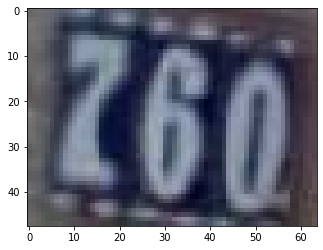

In [202]:
""" PRACTICAL VISUALIZATION OF PREDICTION """
##  [This cell can be run multiple times]  ##

tensor_img, curr_numb = next(newIt)

# Displaying the image:
im = tf.squeeze(tensor_img).numpy()
plt.imshow(im)

# Predicting its label:
pred_label = predict_single_image(tensor_img)
pl = decode_final(pred_label) #decoded Predicted Label
tl = decode_label(curr_numb)  #decoded True Label

from termcolor import colored
if pl == tl:
  print( colored('True Label: ', 'green'), colored(tl, 'green'))
  print( colored('Pred Label: ', 'green'), colored(pl, 'green'))
else:
  print( colored('True Label: ', 'red'), colored(tl, 'red'))
  print( colored('Pred Label: ', 'red'), colored(pl, 'red'))


## Final Comments
With only 14 epochs of training we are able to reach outstanding performances, with about 98% of images in the TEST set correctly classified!

The training process is quite fast, it starts by averaging all the data to the value "10" that which means that no numbers are in the photo, thus it reaches fast 60% of accuracy. Only after the third epoch the model starts to learn effectively.

Eventually, the model becomes very good at its task, being able to classify even some very difficult images.